In [1]:
data = [
    {
      "uri_to_s1": "https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s1/Bhargavi_Khordha_85-88_20-26_2018-12-01_s1.tif",
      "uri_to_s2": "https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif",
      "uri_to_s2_l1c": "https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2_l1c/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2_l1c.tif",
      "uri_to_rgb": "https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/rgb/Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb.tif",
      "uri_to_annotations": "https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/annotations/Bhargavi_Khordha_85-88_20-26_2018-12-01_annotations_3class.geojson",
      "uri_to_rivers": "https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/rivers/Bhargavi_Khordha_85-88_20-26_rivers_1000m.geojson",
      "name": "Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif",
      "cluster_id": 0,
      "latitude": 20.26,
      "longitude": 85.88,
      "date": "2018-12-01"
    },
    {
      "uri_to_s1": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/s1/Waiganga_Gondiya_80-03_21-55_2023-05-01_s1.tif",
      "uri_to_s2": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/s2/Waiganga_Gondiya_80-03_21-55_2023-05-01_s2.tif",
      "uri_to_s2_l1c": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/s2_l1c/Waiganga_Gondiya_80-03_21-55_2023-05-01_s2_l1c.tif",
      "uri_to_rgb": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/rgb/Waiganga_Gondiya_80-03_21-55_2023-05-01_rgb.tif",
      "uri_to_annotations": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/annotations/Waiganga_Gondiya_80-03_21-55_2023-05-01_annotations_3class.geojson",
      "uri_to_rivers": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/rivers/Waiganga_Gondiya_80-03_21-55_rivers_1000m.geojson",
      "name": "Waiganga_Gondiya_80-03_21-55_2023-05-01_s2.tif",
      "cluster_id": 3,
      "latitude": 21.55,
      "longitude": 80.03,
      "date": "2023-05-01"
    },
    {
      "uri_to_s1": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/s1/Waiganga_Gondiya_80-03_21-55_2023-01-01_s1.tif",
      "uri_to_s2": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/s2/Waiganga_Gondiya_80-03_21-55_2023-01-01_s2.tif",
      "uri_to_s2_l1c": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/s2_l1c/Waiganga_Gondiya_80-03_21-55_2023-01-01_s2_l1c.tif",
      "uri_to_rgb": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/rgb/Waiganga_Gondiya_80-03_21-55_2023-01-01_rgb.tif",
      "uri_to_annotations": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/annotations/Waiganga_Gondiya_80-03_21-55_2023-01-01_annotations_3class.geojson",
      "uri_to_rivers": "https://storage.googleapis.com/sand_mining_median/labels/Waiganga_Gondiya_80-03_21-55_median/rivers/Waiganga_Gondiya_80-03_21-55_rivers_1000m.geojson",
      "name": "Waiganga_Gondiya_80-03_21-55_2023-01-01_s2.tif",
      "cluster_id": 3,
      "latitude": 21.55,
      "longitude": 80.03,
      "date": "2023-01-01"
    }
  ]

In [73]:
import json
with open('https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/annotations/Bhargavi_Khordha_85-88_20-26_2018-12-01_annotations_3class.geojson') as f:
    geojson_file = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/annotations/Bhargavi_Khordha_85-88_20-26_2018-12-01_annotations_3class.geojson'

In [ ]:
from torch.utils.data import Dataset
from copy import deepcopy
import torch
from osgeo import gdal

class Img_dataset(Dataset):
    def __init__(self, data, sample_heigth=96, sample_width=96) -> None:
        super().__init__()
        data = deepcopy(data)

        self.sample_heigth = sample_heigth
        self.sample_width = sample_width

        # load data into RAM (not feasible for large data volumes)
        for d in data:
            d['data_s2'] = torch.from_numpy(gdal.Open(d['uri_to_s2']).ReadAsArray())
            d['data_rgb'] = torch.from_numpy(gdal.Open(d['uri_to_rgb']).ReadAsArray())
            d['data_annotations'] = None
            d['data_rivers'] = None
        self.data = data

        # calculate length of dataset
        l = 0
        lengths = [0]
        for d in self.data:
            n_height = d['data_s2'].height - self.sample_heigth + 1
            n_width = d['data_s2'].width - self.sample_width + 1
            l += n_height * n_width
            lengths.append(l)
        self._length = sum(lengths)
        self._observation_pos = lengths

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        if index >= self._length:
            raise ValueError(f'Index {index} out of bounds (max is {self._length})')
        

    

In [ ]:
from torch.utils.data import Dataset
from copy import deepcopy
import torch
from osgeo import gdal

class Observation_dataset(Dataset):
    def __init__(self, data, sample_heigth=96, sample_width=96) -> None:
        super().__init__()
        data = deepcopy(data)

        # load data into RAM (not feasible for large data volumes)
        data['data_s2'] = torch.from_numpy(gdal.Open(data['uri_to_s2']).ReadAsArray())
        data['data_rgb'] = torch.from_numpy(gdal.Open(data['uri_to_rgb']).ReadAsArray())
        data['data_annotations'] = None
        data['data_rivers'] = None
        self.data = data

        # check if sample_heigth and sample_width are valid
        if sample_heigth > data['data_s2'].height:
            raise ValueError('Too large sample_height.')
        if sample_width > data['data_s2'].width:
            raise ValueError('Too large sample_width.')
        self.sample_heigth = sample_heigth
        self.sample_width = sample_width

        # calculate length for better performance
        self._length = (self.data['data_s2'].width - self.sample_width + 1) * \
            (self.data['data_s2'].height - self.sample_height + 1)

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        if index >= self._length:
            raise ValueError(f'Index {index} out of bounds (max is {self._length})')
        top_left_px = index

        s2 = self.data['data_s2'][:,]

        return s2, classes, top_left_px

    

torch.Size([12, 1231, 459])
torch.Size([3, 1231, 459])


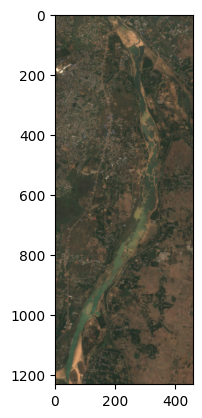

In [12]:
# load data

from osgeo import gdal
import torch
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/37722139/load-a-tiff-stack-in-a-numpy-array-with-python
img_s2 = torch.from_numpy(gdal.Open('/workspaces/code/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif').ReadAsArray())
img_rgb = torch.from_numpy(gdal.Open('/workspaces/code/Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb.tif').ReadAsArray())
print(img_s2.shape)
print(img_rgb.shape)
plt.imshow(img_rgb.permute(1,2,0))

# sampling



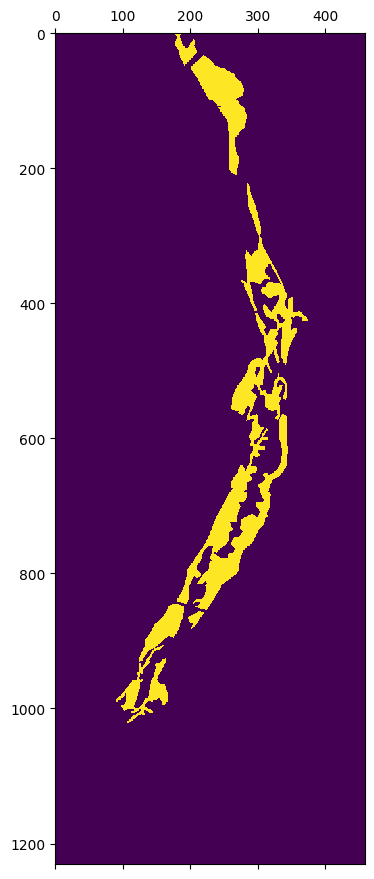

In [70]:
# rasterize classes
import rasterio
from rasterio.features import rasterize
import json

annotation_path = '/workspaces/code/Bhargavi_Khordha_85-88_20-26_2018-12-01_annotations_3class.geojson'
s2_path = '/workspaces/code/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif'

dataset = rasterio.open(s2_path)
with open(annotation_path) as f:
    geojson_file = json.load(f)

shapes = []
for f in geojson_file['features']:
    shapes.append( (f['geometry'],1))

mask = rasterize(
    shapes,
    (dataset.height, dataset.width),
    transform = dataset.transform
)
plt.matshow(mask)

In [64]:
len(geojson_file['features'])

29

In [67]:
geojson_file['features']

[{'geometry': {'type': 'Polygon',
   'coordinates': [[[85.8788824081421, 20.30601355325173],
     [85.87933301925659, 20.306154422110193],
     [85.87986946105958, 20.306516655729194],
     [85.88077068328857, 20.306858764480136],
     [85.88096380233766, 20.306979508564698],
     [85.88126420974733, 20.30710025255509],
     [85.881564617157, 20.306818516431026],
     [85.88162899017335, 20.30641603536447],
     [85.882251, 20.306014],
     [85.882659, 20.304927],
     [85.88238, 20.303337],
     [85.881693, 20.302794],
     [85.881543, 20.302371],
     [85.880985, 20.301928],
     [85.881264, 20.299795],
     [85.881586, 20.299574],
     [85.8815, 20.298507],
     [85.881243, 20.297018],
     [85.880599, 20.297259],
     [85.880256, 20.297783],
     [85.880213, 20.298386],
     [85.88017, 20.299232],
     [85.880213, 20.299876],
     [85.880213, 20.30052],
     [85.880213, 20.301164],
     [85.880213, 20.301808],
     [85.88017, 20.302572],
     [85.880127, 20.303176],
     [85.880084